### Импортируем библиотеки

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

### Пропишем функции преобразования тензора

In [2]:
def img_scaler(image, max_dim = 256):
    # Приводим тензор к новому типу
    original_shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    # Создаем масштаб для изображения
    scale_ratio = 4 * max_dim / max(original_shape)
    # Приводит тензор к новому типу
    new_shape = tf.cast(original_shape * scale_ratio, tf.int32)
    # Изменяет размер изображения на основе константы масштабирования, сгенерированной выше
    return tf.image.resize(image, new_shape)

In [3]:
def load_img(path_to_img):
    #Считывает и выводит все содержимое
    img = tf.io.read_file(path_to_img)
    # Выполняем соответствующую операцию для преобразования входных данных
    # строка байтов в тензор типа dtype
    img = tf.image.decode_image(img, channels=3)
    # Преобразуем изображение в dtype, при необходимости масштабируя
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Масштабируем изображение с помощью созданной функции
    img = img_scaler(img)
    # Добавляем четвертое измерение к тензору, потому что для модели требуется 4-мерный тензор
    return img[tf.newaxis, :]

### Выберем файлы для обработки

In [4]:
name_file = 'IMG_4276'
file_type = '.png'
content_path = 'D:\\Try_hard\\I\\' + name_file + file_type
style_path = 'D:\\Try_hard\\Style\\picture.jpg'

Можно также скачать файлы по ссылке

In [5]:
# content_path = tf.keras.utils.get_file('image.bmp', 
#                                        'Ссылка_на_файл')
# style_path = tf.keras.utils.get_file('style.jpg', 
#                                        'Ссылка_на_файл')

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

Прорисуем импортированные изображения

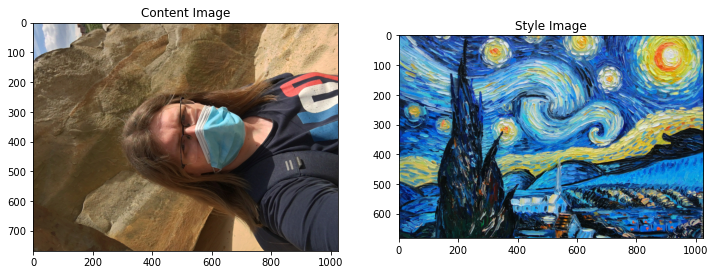

In [7]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(content_image[0])
plt.title('Content Image')
plt.subplot(1, 2, 2)
plt.imshow(style_image[0])
plt.title('Style Image')
plt.show()

Создаем предварительно обученную модель VGG, которая принимает входные данные и возвращает список промежуточных выходных значений

In [8]:
def vgg_layers(layer_names):
    # Загружает предварительно обученный VGG, обученный на данных imagenet
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [9]:
def gram_matrix(input_tensor):
    # Тензорное сжатие по заданным индексам и внешнему произведению (Умножение матриц)
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    # Сохраняем форму входного тензора
    input_shape = tf.shape(input_tensor)
    # Приводит тензор к новому типу
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    # Разделяет выходные данные умножения матрицы
    return result/(num_locations)

In [10]:
# Мы будем использовать слой block5 conv2 для результата
content_layers = ['block5_conv2'] 
# Мы будем использовать слои conv1 из каждого блока для стиля
style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']

In [11]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False
        # Метки при создании словаря
        self.style_layers = style_layers
        self.content_layers = content_layers

    def call(self, inputs):
        # Обработака входного изображения
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        # Передача предварительно обработанного изображения в модель VGG19
        outputs = self.vgg(preprocessed_input)
        # Выходные данные по стилю и содержанию
        style_outputs, content_outputs = (outputs[:len(self.style_layers)], 
                                          outputs[len(self.style_layers):])
        # Обработка вывод стиля перед созданием словаря
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
        # Создание двух словарей для выходных данных контента и стиля
        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        return {'content':content_dict, 'style':style_dict}

In [12]:
extractor = StyleContentModel(style_layers, content_layers)
# Целевые значения стиля и контента:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [13]:
# Создание оптимизатора. Рекомендуется LBFGS, но Адам тоже работает нормально:
opt = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)

# Используем взвешенную комбинацию двух потерь, чтобы получить общую потерю для оптимизации:
style_weight=1e-2
content_weight=1e4

In [14]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

In [15]:
total_variation_weight=500

In [16]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 
                                  clip_value_min=0.0, 
                                  clip_value_max=1.0))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

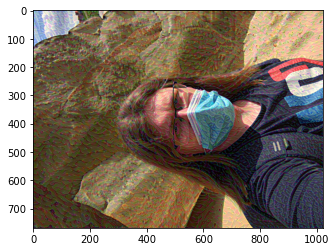

Train step: 25
26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

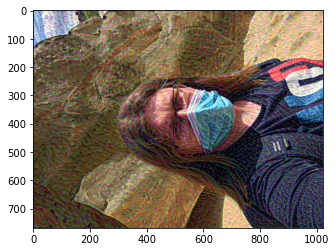

Train step: 50
51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

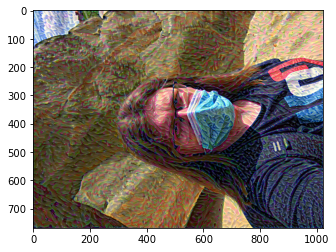

Train step: 75
76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

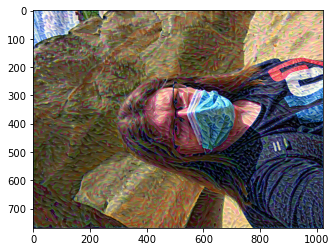

Train step: 100
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 

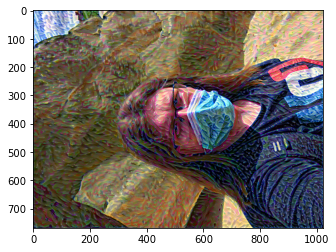

Train step: 125


In [17]:
image = tf.Variable(content_image)
epochs = 5
steps_per_epoch = 25
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(step, end=' ')
        tf.keras.preprocessing.image.save_img('D:/Python/Try_hard/' + name_file +'/' + name_file + str(n * 100 + m) + file_type,
                                              image[0])
    plt.imshow(image[0])
    plt.show()
    print("Train step: {}".format(step))